In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch as th
import matplotlib.pyplot as plt
import os.path
import collections


In [3]:
import numpy as np
from string import Template

def format_top_k(top_k_acc):
    s = [str(acc) for acc in top_k_acc]
    return "$" + " \git ".join(s) + "$"

def format_float(s):
    return "$" + str(s) + "$"


def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', r'\text{K}', r'\text{M}', r'\text{B}', 'T'][magnitude])


def print_result_all(datasets, K_index=[0,2,4,5]):
    beginning = r"""\begin{table}[h!]
    \resizebox{\textwidth}{!}{%
\begin{tabular}{|c|cll|cll|cll|cll|}
\hline
                       & \multicolumn{3}{c|}{AUC}                                                              & \multicolumn{3}{c|}{Log likelihood}                                                   & \multicolumn{3}{c|}{Top-K accuracy}                                                   & \multicolumn{3}{c|}{Inference time}                                                   \\ \hline
Dataset                & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} \\ \hline
"""
    
    
    end = r"""
    \end{tabular}}
    \label{tbl:all-results}
    \end{table}"""
    
    print(beginning)
    prec = 3
    for dataset, link in datasets.items():
        res = th.load(link)
        auc_ase = res["auc_spectral"]
        auc_mmle = res["auc_mmle"]
        auc_cmle = res["auc_cmle"] if "auc_cmle" in res else "N/A"
            
        time_ase = res["time_spectral"]
        time_mmle = res["time_mmle"]
        time_cmle = res["time_cmle"] if "time_cmle" in res else "N/A"
            
        
        loglik_ase = res["loglik_spectral"]
        loglik_mmle = res["loglik_mmle"]
        loglik_cmle = res["loglik_cmle"] if "loglik_cmle" in res else "N/A"
        
        top_k_ase = None
        top_k_mmle = None
        top_k_cmle = None
        if dataset not in ["lsat", "uci", "three grades"]:
            top_k_ase = np.array(res["top_k_spectral"])
            top_k_mmle = np.array(res["top_k_mmle"])
            top_k_cmle = np.array(res["top_k_cmle"]) if "top_k_cmle" in res else "N/A"
        
        line = r" {$dataset} & \multicolumn{1}{c|}{$auc_ase} & \multicolumn{1}{c|}{$auc_mmle}  & {$auc_cmle}" + \
               r" & \multicolumn{1}{c|}{$loglik_ase} & \multicolumn{1}{c|}{$loglik_mmle}  & {$loglik_cmle} " + \
               r" & \multicolumn{1}{c|}{$top_k_ase} & \multicolumn{1}{c|}{$top_k_mmle}  & {$top_k_cmle}" + \
               r" & \multicolumn{1}{c|}{$time_ase} & \multicolumn{1}{c|}{$time_mmle} & {$time_cmle} \\ \hline"
                
        line = Template(line).substitute(
            dataset=dataset,
            auc_ase=format_float(np.around(auc_ase, prec)) if auc_ase != "N/A"  else "N/A",
            auc_mmle=format_float(np.around(auc_mmle, prec)) if auc_mmle != "N/A"  else "N/A",
            auc_cmle=format_float(np.around(auc_cmle, prec)) if auc_cmle != "N/A"  else "N/A",
            loglik_ase=format_float(np.around(loglik_ase, prec)) if loglik_ase != "N/A"  else "N/A",
            loglik_mmle=format_float(np.around(loglik_mmle, prec)) if loglik_mmle != "N/A"  else "N/A",
            loglik_cmle=format_float(np.around(loglik_cmle, prec)) if loglik_cmle != "N/A" else "N/A",
            time_ase=format_float(human_format(np.around(time_ase, prec))) if time_ase != "N/A" else "N/A",
            time_mmle=format_float(human_format(np.around(time_mmle, prec))) if time_mmle != "N/A" else "N/A",
            time_cmle=format_float(human_format(np.around(time_cmle, prec))) if time_cmle != "N/A"  else "N/A",
            top_k_ase=format_top_k(np.around(top_k_ase[K_index], prec)) if top_k_ase is not None else "N/A",
            top_k_mmle=format_top_k(np.around(top_k_mmle[K_index], prec)) if top_k_mmle is not None else "N/A",
            top_k_cmle=format_top_k(np.around(top_k_cmle[K_index], prec)) if top_k_cmle is not None and type(top_k_cmle) != str else "N/A",
        )
        
        print(line)
        
    print(end)
    return None


def print_results_all_v2(datasets, K_index=[0,2,4,5]):
    beginning = r"""\begin{table}[]
    \resizebox{1.2\textwidth}{!}{%
\begin{tabular}{|c|cccc|cccc|cccc|cccc|}
\hline
          & \multicolumn{4}{c|}{AUC}  & \multicolumn{4}{c|}{Log likelihood}   & \multicolumn{4}{c|}{Top-K accuracy}  & \multicolumn{4}{c|}{Inference time}  \\ \hline
Dataset   & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} & JMLE & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} & JMLE & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} & JMLE & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} & JMLE \\ \hline"""
    
    
    end = r"""
    \end{tabular}}
    \label{tbl:all-results}
    \end{table}"""
    
    print(beginning)
    prec = 3
    
    for dataset, link in datasets.items():
        spectral_mmle_name = link + "_spectral+MMLE.th"
        
        if os.path.isfile(spectral_mmle_name):
            res = th.load(spectral_mmle_name) if os.path.isfile(spectral_mmle_name) else collections.defaultdict(lambda: "N/A")
            auc_ase = res["auc_spectral"]
            auc_mmle = res["auc_mmle"]
            time_ase = res["time_spectral"]
            time_mmle = res["time_mmle"]        
            loglik_ase = res["loglik_spectral"]
            loglik_mmle = res["loglik_mmle"]
            num_prior_dist = len(res["students_vars"])
            top_k_ase = None
            top_k_mmle = None
            if dataset not in ["lsat", "uci", "3 grades", "riiid", "riiid-small"]:
                top_k_ase = np.array(res["top_k_spectral"])
                top_k_mmle = np.array(res["top_k_mmle"])
        else:
            res = th.load(link + "_spectral.th") if os.path.isfile(link + "_spectral.th") else collections.defaultdict(lambda: "N/A")
            auc_ase = res["auc_spectral"]
            time_ase = res["time_spectral"]
            loglik_ase = res["loglik_spectral"]
            
            top_k_ase = None
            if dataset not in ["lsat", "uci", "3 grades", "riiid", "riiid-small"]:
                top_k_ase = np.array(res["top_k_spectral"])
                
            res = th.load(link + "_MMLE.th") if os.path.isfile(link + "_MMLE.th") else collections.defaultdict(lambda: "N/A")
            auc_mmle = res["auc_mmle"]
            time_mmle = res["time_mmle"]         
            loglik_mmle = res["loglik_mmle"]
            num_prior_dist = len(res["students_vars"])
            top_k_mmle = None
            if dataset not in ["lsat", "uci", "3 grades", "riiid", "riiid-small"]:
                top_k_mmle = np.array(res["top_k_mmle"])
        
        
        jmle_name = link + "_JMLE.th"
        res = th.load(jmle_name) if os.path.isfile(jmle_name) else {}
        auc_jmle = res["auc_jmle"] if "auc_jmle" in res else "N/A"
        time_jmle = res["time_jmle"] if "time_jmle" in res else "N/A"
        loglik_jmle = res["loglik_jmle"] if "loglik_jmle" in res else "N/A"
        top_k_jmle = None
        if dataset not in ["lsat", "uci", "3 grades", "riiid", "riiid-small"]:
            top_k_jmle = np.array(res["top_k_jmle"]) if "top_k_jmle" in res else "N/A"
        
        
        cmle_name = link + "_CMLE.th"
        res = th.load(cmle_name) if os.path.isfile(cmle_name) else dict()
        
        auc_cmle = res["auc_cmle"] if "auc_cmle" in res else "N/A"
        time_cmle = res["time_cmle"] if "time_cmle" in res else "N/A"
        loglik_cmle = res["loglik_cmle"] if "loglik_cmle" in res else "N/A"
        top_k_cmle = None
        if dataset not in ["lsat", "uci", "3 grades", "riiid", "riiid-small"]:
            top_k_cmle = np.array(res["top_k_cmle"]) if "top_k_cmle" in res else "N/A"
            
        line = r" {$dataset} & \multicolumn{1}{c|}{$auc_ase} & \multicolumn{1}{c|}{$auc_mmle} & \multicolumn{1}{c|}{$auc_cmle}  & {$auc_jmle}" + \
               r" & \multicolumn{1}{c|}{$loglik_ase} & \multicolumn{1}{c|}{$loglik_mmle} & \multicolumn{1}{c|}{$loglik_cmle} & {$loglik_jmle} " + \
               r" & \multicolumn{1}{c|}{$top_k_ase} & \multicolumn{1}{c|}{$top_k_mmle} & \multicolumn{1}{c|}{$top_k_cmle} & {$top_k_jmle}" + \
               r" & \multicolumn{1}{c|}{$time_ase} & \multicolumn{1}{c|}{$time_mmle} & \multicolumn{1}{c|}{$time_cmle} & {$time_jmle} \\ \hline"
        
        # print(dataset, top_k_mmle)
        
        line = Template(line).substitute(
            dataset=dataset.upper(),
            auc_ase=format_float(np.around(auc_ase, prec)) if auc_ase != "N/A"  else "N/A",
            auc_mmle=format_float(np.around(auc_mmle, prec)) if auc_mmle != "N/A"  else "N/A",
            auc_cmle=format_float(np.around(auc_cmle, prec)) if auc_cmle != "N/A"  else "N/A",
            auc_jmle=format_float(np.around(auc_jmle, prec)) if auc_jmle != "N/A"  else "N/A",
            loglik_ase=format_float(np.around(loglik_ase, prec)) if loglik_ase != "N/A"  else "N/A",
            loglik_mmle=format_float(np.around(loglik_mmle, prec)) if loglik_mmle != "N/A"  else "N/A",
            loglik_cmle=format_float(np.around(loglik_cmle, prec)) if loglik_cmle != "N/A" else "N/A",
            loglik_jmle=format_float(np.around(loglik_jmle, prec)) if loglik_jmle != "N/A" else "N/A",
            time_ase=format_float(human_format(np.around(time_ase, prec))) if time_ase != "N/A" else "N/A",
            time_mmle=format_float(human_format(np.around(time_mmle*num_prior_dist, prec))) if time_mmle != "N/A" else "N/A",
            time_cmle=format_float(human_format(np.around(time_cmle, prec))) if time_cmle != "N/A"  else "N/A",
            time_jmle=format_float(human_format(np.around(time_jmle, prec))) if time_jmle != "N/A"  else "N/A",
            top_k_ase=format_top_k(np.around(top_k_ase[K_index], prec)) if (top_k_ase is not None and top_k_ase != "N/A") else "N/A",
            top_k_mmle=format_top_k(np.around(top_k_mmle[K_index], prec)) if (top_k_mmle is not None and top_k_mmle != "N/A") else "N/A",
            top_k_cmle=format_top_k(np.around(top_k_cmle[K_index], prec)) if (top_k_cmle is not None and top_k_cmle != "N/A") else "N/A",
            top_k_jmle=format_top_k(np.around(top_k_jmle[K_index], prec)) if (top_k_jmle is not None and top_k_jmle != "N/A") else "N/A",
        )
        
        print(line)
        
    print(end)
    return None



def plot_ell2_synthetic(dataset, link, full=False, from_ind=0):
    res = th.load(link)
    err_spectral = np.array(res["errors_spectral"])
    err_mmle = np.array(res["errors_mmle"])
    err_cmle = np.array(res["errors_cmle"])
    err_jmle = np.array(res["errors_jmle"])
    
    err_choppin = np.array(res["errors_choppin"])
    err_saaty = np.array(res["errors_saaty"])
    err_pair = np.array(res["errors_pair"])
    
    n_array = res["n_array"]
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(n_array[from_ind:], np.mean(err_spectral, 1)[from_ind:], label="Spectral")    
    ax.plot(n_array[from_ind:], np.mean(err_mmle, 1)[from_ind:], label="MMLE")
    ax.plot(n_array[from_ind:], np.mean(err_cmle, 1)[from_ind:], label="CMLE")
    ax.plot(n_array[from_ind:], np.mean(err_jmle, 1)[from_ind:], label="JMLE")
    if full:
        ax.plot(n_array[from_ind:], np.mean(err_choppin, 1)[from_ind:], label="Choppin")
        ax.plot(n_array[from_ind:], np.mean(err_saaty, 1)[from_ind:], label="Saaty")
        ax.plot(n_array[from_ind:], np.mean(err_pair, 1)[from_ind:], label="Pair MLE")

    ax.legend(fontsize=14)
    ax.set_xlabel("n", fontsize=14)
    ax.set_ylabel(r"$|| \beta - \beta^*||$", fontsize=14)
    ax.set_title(dataset, fontsize=14)
    fig.tight_layout()
    return fig, ax


def plot_time_synthetic(dataset, link, full=False, from_ind=0):
    res = th.load(link)
    err_spectral = np.array(res["time_spectral"])
    err_mmle = np.array(res["time_mmle"])
    err_cmle = np.array(res["time_cmle"])
    err_jmle = np.array(res["time_jmle"])
    err_choppin = np.array(res["time_choppin"])
    err_saaty = np.array(res["time_saaty"])
    err_pair = np.array(res["time_pair"])

    
    n_array = res["n_array"]
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(n_array, np.mean(err_spectral, 1), label="Spectral")    
    ax.plot(n_array, np.mean(err_mmle, 1), label="MMLE")
    ax.plot(n_array, np.mean(err_cmle, 1), label="CMLE")
    ax.plot(n_array, np.mean(err_jmle, 1), label="JMLE")
    if full:
        ax.plot(n_array, np.mean(err_choppin, 1), label="Choppin")
        ax.plot(n_array, np.mean(err_saaty, 1), label="Saaty")
        ax.plot(n_array, np.mean(err_pair, 1), label="Pair MLE")

    ax.legend(fontsize=14)
    ax.set_xlabel("n", fontsize=14)
    ax.set_ylabel(r"Time (s)", fontsize=14)
    ax.set_title(dataset, fontsize=14)
    fig.tight_layout()
    return fig, ax


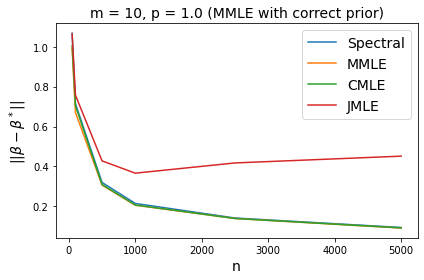

In [23]:
full = False
from_ind = 0
fig, ax = plot_ell2_synthetic("m = 10, p = 1.0 (MMLE with correct prior)", "../experiment_results/may/may5/synthetic_m=10_p=1.0_testvar=1.0_stuvar=1.0.th", full, from_ind=from_ind)

if full:
    fig.savefig("pics/synthetic_small_p=1_all.png")
else:
    fig.savefig("pics/synthetic_small_p=1.png")

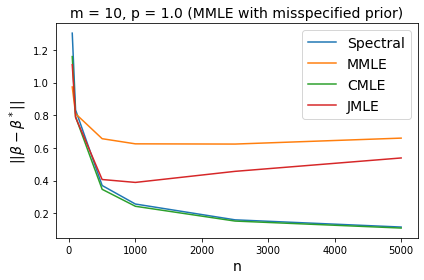

In [24]:
full = False
from_ind = 0

fig, ax = plot_ell2_synthetic("m = 10, p = 1.0 (MMLE with misspecified prior)", "../experiment_results/may/may5/synthetic_m=10_p=1.0_testvar=1.0_stuvar=2.0.th", full, from_ind=from_ind)

if full:
    fig.savefig("pics/synthetic_small_misspecified_p=1_all.png")
else:
    fig.savefig("pics/synthetic_small_misspecified_p=1.png")

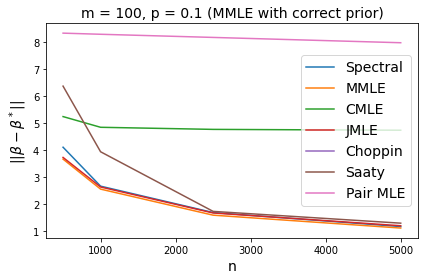

In [15]:
full = True
from_ind = 2
fig, ax = plot_ell2_synthetic("m = 100, p = 0.1 (MMLE with correct prior)", "../experiment_results/may/may4/synthetic_m=100_p=0.1_testvar=1.0_stuvar=1.0.th", full, from_ind=from_ind)
if full:
    fig.savefig("pics/synthetic_large_sparse_p=0.1_all.png")
else:
    fig.savefig("pics/synthetic_large_sparse_p=0.1.png")

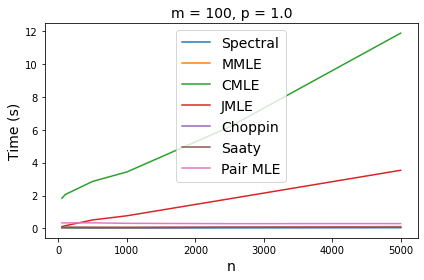

In [11]:
full = True
fig, ax = plot_time_synthetic("m = 100, p = 1.0", "../experiment_results/may/may4/synthetic_m=100_p=1.0_testvar=1.0_stuvar=1.0.th", full)

if full:
    fig.savefig("pics/synthetic_large_p=1.0_time_all.png")
else:
    fig.savefig("pics/synthetic_large_p=1.0_time.png")

In [7]:

datasets = {
    "lsat" : "../experiment_results/apr/apr29/lsat_m=5_119_0.8_ALL_CV.th",
    "uci" : "../experiment_results/apr/apr29/uci_student_m=4_119_0.8_ALL_CV.th",
    "3 grades" : "../experiment_results/apr/apr29/grades_three_m=3_119_0.8_ALL_CV.th",
    "hetrec" : "../experiment_results/apr/apr29/hetrec_2k_m=4735_119_0.8_ALL_CV.th",
    "ml-100k" : "../experiment_results/apr/apr29/ml_100k_m=1050_119_0.8_ALL_CV.th",
    "ml-1m" : "../experiment_results/apr/apr29/ml_1m_m=2934_119_0.8_ALL_CV.th", # Missing CMLE
    "ml-10m" : "../experiment_results/apr/apr29/ml_10m_m=7259_119_0.8_mmle+spectral_CV.th",
    "ml-20m" : "../experiment_results/apr/apr29/ml_20m_m=8546_119_0.8_mmle+spectral_CV.th",
    "book-genome" : "../experiment_results/apr/apr29/book_genome_m=7238_119_0.8_mmle+spectral_CV.th",
    "BX" : "../experiment_results/apr/apr29/bx_book_m=2185_119_0.8_ALL_CV.th",
    "each movie": "../experiment_results/apr/apr29/each_movie_m=1157_119_0.8_ALL_CV.th",
}

# Deciding between May3rd result and May4th result

datasets_v2 = {
    "lsat" : "../experiment_results/may/may5/lsat_m=5_119_0.8",
    "uci" : "../experiment_results/may/may5/uci_student_m=4_119_0.8",
    "3 grades" : "../experiment_results/may/may5/grades_three_m=3_119_0.8",
    # "riiid-small" : "../experiment_results/may/may5/riiid_m=2807_119_0.8",
    "riiid" : "../experiment_results/may/may5/riiid_small_m=6311_119_0.8",
    "hetrec" : "../experiment_results/may/may5/hetrec_2k_m=6829_119_0.8",
    "ml-100k" : "../experiment_results/may/may5/ml_100k_m=2269_119_0.8",
    "ml-1m" : "../experiment_results/may/may5/ml_1m_m=3260_119_0.8",
    "each movie": "../experiment_results/may/may5/each_movie_m=1327_119_0.8",
    "ml-10m": "../experiment_results/may/may5/ml_10m_m=8653_119_0.8",
    # "ml-20m": "../experiment_results/may/may2/ml_20m_m=10524_119_0.8",
    "ml-20m": "../experiment_results/may/may5/ml_20m_m=10524_119_0.8",
    "bx" : "../experiment_results/may/may5/bx_book_m=2185_119_0.8",
    # "book genome" : "../experiment_results/may/may3/book_genome_m=7238_119_0.8",
    "book-genome": "../experiment_results/may/may5/book_genome_m=9374_119_0.8"
}

synthetic_datasets = {
    
    
}


In [8]:


print_results_all_v2(datasets_v2, K_index=[0,1,2])

\begin{table}[]
    \resizebox{1.2\textwidth}{!}{%
\begin{tabular}{|c|cccc|cccc|cccc|cccc|}
\hline
          & \multicolumn{4}{c|}{AUC}  & \multicolumn{4}{c|}{Log likelihood}   & \multicolumn{4}{c|}{Top-K accuracy}  & \multicolumn{4}{c|}{Inference time}  \\ \hline
Dataset   & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} & JMLE & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} & JMLE & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} & JMLE & \multicolumn{1}{c|}{Spectral} & \multicolumn{1}{c|}{MMLE} & \multicolumn{1}{c|}{CMLE} & JMLE \\ \hline
 {LSAT} & \multicolumn{1}{c|}{$0.707$} & \multicolumn{1}{c|}{$0.707$} & \multicolumn{1}{c|}{$0.707$}  & {$0.707$} & \multicolumn{1}{c|}{$-0.487$} & \multicolumn{1}{c|}{$-0.489$} & \multicolumn{1}{c|}{$-0.487$} & {$-0.485$}  & \multicolumn{1}{c|}{N/A} & \multicolumn{1}{c|}{N/A} & \multicolumn{1}{c|}{N/A} & {N/A} & \multicolumn{1}{c|}{

<ipython-input-3-32f173264986>:183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  top_k_ase=format_top_k(np.around(top_k_ase[K_index], prec)) if (top_k_ase is not None and top_k_ase != "N/A") else "N/A",
<ipython-input-3-32f173264986>:184: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  top_k_mmle=format_top_k(np.around(top_k_mmle[K_index], prec)) if (top_k_mmle is not None and top_k_mmle != "N/A") else "N/A",
<ipython-input-3-32f173264986>:185: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  top_k_cmle=format_top_k(np.around(top_k_cmle[K_index], prec)) if (top_k_cmle is not None and top_k_cmle != "N/A") else "N/A",
<ipython-input-3-32f173264986>:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will per